In [1]:
library(tidyverse)
options(repr.plot.width=5, repr.plot.height=4)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.4.1
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# STATS 306
## Homework 5: Relational Data and SQL

For each problem, enter the R code in the cell marked "YOUR SOLUTION HERE". All of the problems in this problem set use the `nycflights13` data:

This package provides the following data tables.

* `?flights`: all flights that departed from NYC in 2013
* `?weather`: hourly meterological data for each airport
* `?planes`: construction information about each plane
* `?airports`: airport names and locations
* `?airlines`: translation between two letter carrier codes and names

In [2]:
install.packages('nycflights13') # if necessary

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
library(nycflights13)

## Problem 1: Joins (4 points)


**(a)** Is there a relationship between a) a plane's age, and b) the proportion of flights schedule to use that plane that got cancelled? Here we consider a flight cancellation to be when `dep_time` is `NA` as described in HW 3 Problem 1 (b): 1 point

There seems to be no relationship between a plane's age and the proportion of flights that got cancelled.

Joining with `by = join_by(tailnum)`
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


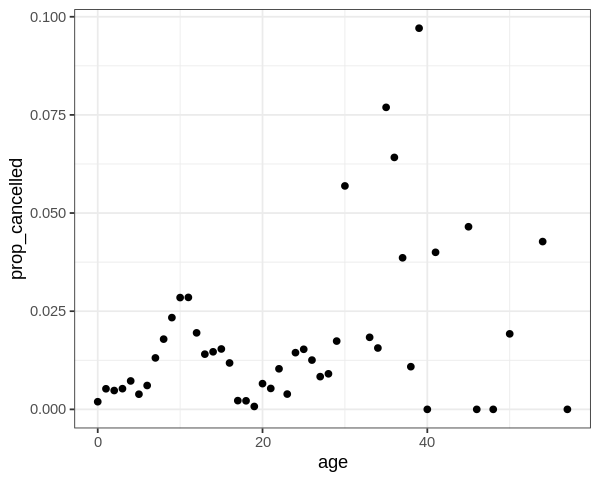

In [4]:
# Your solution here
#age_cancel <- flights %>% left_join(planes, join_by(tailnum)) %>%
 #  group_by(year.x, year.y, dep_time) %>% mutate(age = year.x - year.y) %>%
  # group_by(tailnum) %>% mutate(prop_cancelled = mean(ifelse(is.na(dep_time), 1, 0)))
#age_cancel %>% ggplot(aes(x = age, y = prop_cancelled)) + geom_point() 
flights %>% select(tailnum, dep_time) %>%
  inner_join(select(planes, tailnum, year)) %>%
  mutate(age = 2013-year) %>%
  group_by(age) %>%
  summarize(prop_cancelled = mean(is.na(dep_time))) %>%
  ggplot(aes(x=age, y=prop_cancelled)) + geom_point() +
  theme_bw()

**(b)** Are some planes used by multiple carriers? (Recall that each plane is uniquely identified by its `tailnum`.) _1 point_

Yes, since the table below shows that the count for certain planes is more than 1, this means some planes were used by multiple carriers.

In [8]:
# Your solution here
#flights %>% 
 # left_join(planes, by='tailnum') %>% 
  #  group_by(tailnum, carrier) %>% 
   #   summarise(n = n()) %>% count(tailnum) %>% filter(n > 1) %>% print
flights %>% filter(!is.na(tailnum)) %>% select(tailnum, carrier) %>%
  group_by(tailnum) %>% summarize(n_carriers = n_distinct(carrier), .groups = "drop") %>%
  arrange(desc(n_carriers)) %>% print
flights %>% filter(tailnum == "N146PQ") %>% count(carrier)

# A tibble: 4,043 × 2
   tailnum n_carriers
   <chr>        <int>
 1 N146PQ           2
 2 N153PQ           2
 3 N176PQ           2
 4 N181PQ           2
 5 N197PQ           2
 6 N200PQ           2
 7 N228PQ           2
 8 N232PQ           2
 9 N933AT           2
10 N935AT           2
# ℹ 4,033 more rows


carrier,n
<chr>,<int>
9E,8
EV,36


install.packages("maps")In the next few problems you are asked to draw some data on a map of the United States. Fortunately, this is easy to do using `ggplot`. Here is an example which draws the location of each airport in the dataset:

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



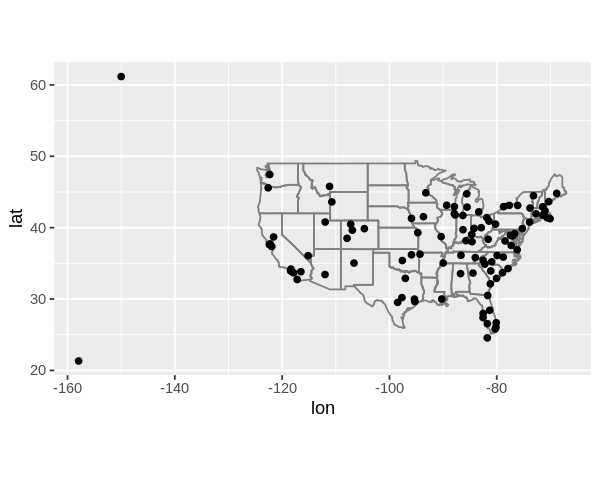

In [11]:
install.packages("maps") # if necessary
airports  %>% 
  semi_join(flights, by=c("faa"="dest")) %>% 
  ggplot(aes(x = lon, y = lat)) +
    borders("state") +
    geom_point() +
    coord_quickmap()

**(c)** For each destination in the continental U.S., compute the average arrival delay to that destination, and draw them on a map: _1 point_

`summarise()` has grouped output by 'dest', 'lat'. You can override using the
`.groups` argument.
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”


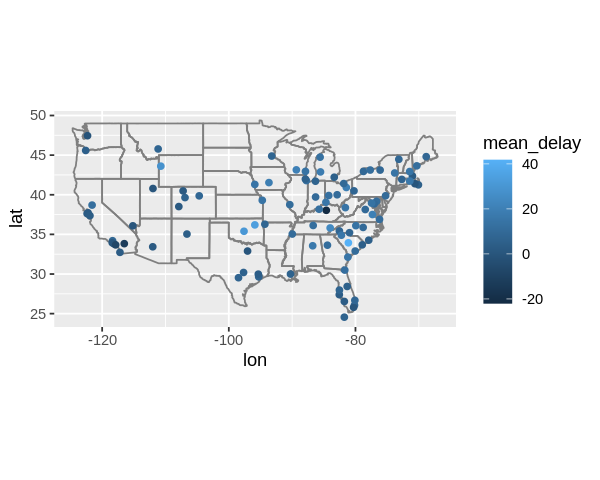

In [ ]:
# Your solution here
avg <- flights %>% group_by(dest) %>% 
    summarize(mean_delay = mean(arr_delay, na.rm = TRUE))
left_join(flights, airports, by= c("dest" = "faa"), multiple = 'all') %>% group_by(dest, lat, lon) %>%
  summarize(mean_delay = mean(arr_delay, na.rm = TRUE)) %>% filter(dest != "ANC" & dest != "HNL") %>%
  ggplot(aes(x = lon, y = lat)) +
    borders("state") +
    geom_point(aes(color = mean_delay)) +
    coord_quickmap()

**(d)** Draw a map of the total number of passengers that flew from NYC to each destination airport in the continental US. (Hint: assume every flight was full, and use the `seats` variable in `planes` to estimate the number of passengers.) _1 point_

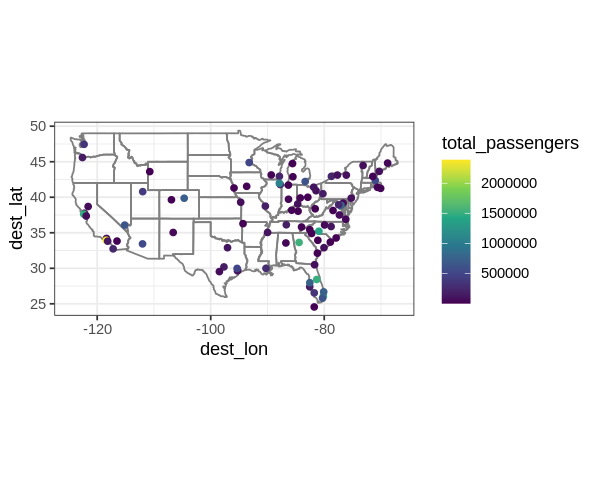

In [12]:
# Your solution here
#passengers <- left_join(flights, planes, join_by(tailnum), multiple = 'all') %>% group_by(origin, dest) %>%
 # summarize(total_seats = sum(seats, na.rm = FALSE)) %>% filter(origin == "LGA"|origin == "JFK")
#left_join(passengers, airports, by = c("dest" = "faa")) %>% group_by(total_seats, lon, lat) %>%
 # ggplot(aes(x = lon, y = lat)) +
 #   borders("state") +
  #  geom_point(aes(color = total_seats)) +
  #  coord_quickmap()
flights %>% select(tailnum, dest, origin) %>% filter(origin %in% c("JFK", "LGA")) %>%
  inner_join(select(airports, dest = faa, dest_lat = lat, dest_lon = lon),
by = "dest") %>%
  filter(dest_lon > -130, dest_lon < -65) %>%
  inner_join(select(planes, tailnum, seats),
by = "tailnum") %>% group_by(dest) %>%
  summarize(dest_lat = first(dest_lat),
dest_lon = first(dest_lon),
total_passengers = sum(seats)) %>%
  ggplot(aes(dest_lon, dest_lat, color = total_passengers)) +
  borders("state") + geom_point() + coord_quickmap() +
  scale_color_continuous(type = "viridis") + theme_bw()

## Problem 2, Weather Delays (4 points)

Use the tables in the `nycflights13` package to answer the following questions:



**(a)** The average departure delay during the first two days of the year was:

In [13]:
flights %>% filter(month == 1, day %in% c(1, 2)) %>% summarise(mean(dep_delay, na.rm = T)) %>% print

# A tibble: 1 × 1
  `mean(dep_delay, na.rm = T)`
                         <dbl>
1                         12.8


whereas for the second two days of the year it was: 

In [14]:
flights %>% filter(month == 1, day %in% c(2, 3)) %>% summarise(mean(dep_delay, na.rm = T)) %>% print

# A tibble: 1 × 1
  `mean(dep_delay, na.rm = T)`
                         <dbl>
1                         12.4


What are the two consecutive days in flights with the highest average departure delay? (Hint: use the `lag()` function.) _2 points_

July 22 and 23 are the two consecutive days in flights with the highest average departure delay.

In [15]:
# Your solution here
#flights %>%
 # group_by(month, day) %>%
 # summarize(tot_delay = sum(arr_delay + dep_delay, na.rm = TRUE)) %>%
 # mutate(twoday = tot_delay + lag(tot_delay)) %>%
 # arrange(desc(twoday)) %>% print
flights %>% group_by(month, day) %>% filter(dep_delay > 0) %>%
  summarize(n = n(), dep_delay = sum(dep_delay, na.rm = T), .groups = "drop") %>%
  mutate(average_twoday = (dep_delay + lag(dep_delay))/(n + lag(n))) %>%
  arrange(desc(average_twoday)) %>% slice(1)

month,day,n,dep_delay,average_twoday
<int>,<int>,<int>,<dbl>,<dbl>
9,2,460,46774,82.01872


**(b)** Which of humidity, temperature, or precipitation is more likely to cause flight cancellations? (Here cancelation is defined as it was in Problem 1(a).) Study this by comparing the joint distribution of a) the fraction of flights that were cancelled each day and b) (a summary of) each of the three measurements shown above. 

(Hint: use `pivot_longer` to create a data frame with a variable that contains `humidity`, `temperature`, and `precipitation` as values): _2 points_

`summarise()` has grouped output by 'month'. You can override using the
`.groups` argument.
Joining with `by = join_by(month, day)`
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 3 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”


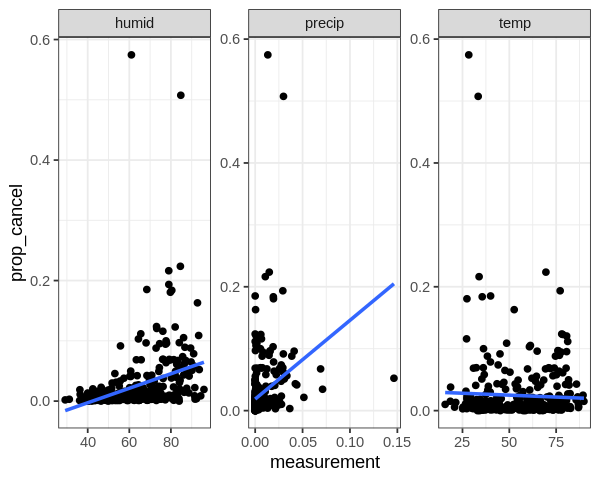

In [16]:
# Your solution here
#weather <- flights %>%
 # left_join(weather, by = 'time_hour')  %>%
#group_by(humid, temp, precip) %>%
 # summarize(Avg_dep_delay = mean(dep_time, na.rm = TRUE))
avg_weather <- weather %>% group_by(month, day) %>%
  summarize_at(vars(humid, temp, precip), mean, na.rm = T, .groups = "drop")
flights %>% group_by(month, day) %>% summarize(prop_cancel = mean(is.na(dep_time))) %>%
  left_join(avg_weather) %>%
  pivot_longer(cols = c(humid, precip, temp), 
names_to = "weather_type", values_to = "measurement") %>%
  ggplot(aes(measurement, prop_cancel)) +
  geom_point() + geom_smooth(method = "lm", se=FALSE) +
  facet_wrap(weather_type~., scales="free") + theme_bw() 

## Challenge problem: Writing SQL queries ( 2 points)
The following code loads `nycflights13` into a SQLite database:

In [17]:
install.packages('RSQLite') # if necessary

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plogr’




In [18]:
# SQLite database
library(nycflights13)
library(DBI)
library(RSQLite)
con <- dbConnect(SQLite(), ":memory:")
copy_to(con, flights, "flights")
copy_to(con, airports, "airports")
copy_to(con, airlines, "airlines")

For each question below, write an appropriate SQL query that produces the answer. For example, if the question was "How many flights departed each month", an appropriate answer would be:

In [19]:
dbGetQuery(con, "SELECT month, COUNT(month) FROM flights GROUP BY month")

month,COUNT(month)
<int>,<int>
1,27004
2,24951
3,28834
4,28330
5,28796
6,28243
7,29425
8,29327
9,27574


**Your answers should only use SQL -- no dplyr allowed!** (However, it is fine to use dplyr to check your answers.)

**(a)** Find the origin and destination with the longest trip for each carrier in the whole dataset, and order your result based on the maximum `air_time`. : 1/2 point

In [20]:
# Your solution here
dbGetQuery(con, "SELECT carrier, origin, dest, max(air_time) AS max_air_time
 FROM flights GROUP BY carrier ORDER BY max_air_time DESC")

carrier,origin,dest,max_air_time
<chr>,<chr>,<chr>,<dbl>
UA,EWR,HNL,695
HA,JFK,HNL,691
DL,JFK,SFO,490
AA,JFK,SFO,426
B6,JFK,SAN,413
VX,JFK,SFO,406
AS,EWR,SEA,392
WN,EWR,PHX,362
US,JFK,PHX,359


**(b)** Find all the busy routes in December 2013 with more than 500 flights in total. (Your query should return the route's origin, destination, and the number of flights.): 1/2 point

In [21]:
# Your solution here
dbGetQuery(con, "SELECT origin, dest, COUNT(*) AS cnt 
FROM flights 
WHERE year = 2013 AND month = 12
GROUP BY origin, dest
HAVING cnt > 500
ORDER BY cnt DESC")

origin,dest,cnt
<chr>,<chr>,<int>
JFK,LAX,947
LGA,ATL,862
JFK,SFO,698
LGA,ORD,637
LGA,MIA,575
LGA,CLT,535


**(c)** What percentage of the flights were cancelled overall? (A cancelled flight is one for which `dep_delay` is missing.): 1/2 point

In [22]:
# Your solution here
dbGetQuery(con, "SELECT 1 - 1.00*count(dep_delay)/ count(*)
AS cancel FROM flights")

cancel
<dbl>
0.02451184


**(d)** How many flights are there for each weekday? (Your query should return two columns `num` and `weekday`, where `num` is the number of flights, and `weekday` is the day of week with numerical expressions such as Sunday=0, Monday=1, etc.): 1/2 point

In [24]:
# Your solution here
dbGetQuery(con, "SELECT COUNT(*) as num, strftime('%w', datetime(time_hour, 'unixepoch')) AS weekday
FROM flights
GROUP BY weekday")

num,weekday
<int>,<chr>
43796,0
50709,1
50705,2
49998,3
50137,4
50153,5
41278,6
